In [1]:
import os
import nibabel as nib
import sys
import tensorflow as tf
import pandas as pd 
import numpy as np
import subprocess
from glob import glob
from tensorflow import keras
from nilearn import image
from sklearn.model_selection import train_test_split

2023-11-20 17:29:36.809517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 17:29:38.059745: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-20 17:29:38.061549: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-20 17:29:38.061597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
cd

/home/athurai3


In [3]:
#hyperparameters
batch_size = 2 #image data gen to read array generator from c3d*

patch_radius= np.array([31,31,31]) #in voxels -- patch will be shape: 1+2*radius

#3D rotation augmentation; only for training set
num_augment = 2 #number of augmentations per patch
angle_stdev = 30 #stdev of normal distribution for sampling angle (in degrees)

#sampling radius
radius = patch_radius 

num_channels = 2 #ct and corresponding electrode mask


#creating sampling radius argument (R0xR1xR2)
radius_arg = 'x'.join([str(rad) for rad in radius])

#patch shape = 1+2*radius
dims = 1+2*radius

In [4]:
#patches_path = 'scratch/test_preproc_contact_loc//sub-P001/sub-P001_res-0p5mm_patches.dat'
#patches_path_2 = 'projects/ctb-akhanf/athurai3/contact_localization/sub-P001_patches.dat'

In [30]:
patches_thresh = 'projects/ctb-akhanf/athurai3/contact_localization/sub-P001_patches_thresh.dat'

In [31]:
patches_plain = 'projects/ctb-akhanf/athurai3/contact_localization/sub-P001_patches.dat'

In [32]:
cd

/home/athurai3


In [33]:
bps = 4 * num_channels * np.prod(dims)         # Bytes per sample
file_size = os.path.getsize(patches_thresh) 
num_samples = np.floor_divide(file_size,bps)   # Number of samples
print(file_size)
print(bps)
print(num_samples)

dims = dims.astype('int')
arr_shape_train = (num_samples,dims[0],dims[1],dims[2],num_channels)

arr_train = np.memmap(patches_thresh,'float32','r+',shape=arr_shape_train)
arr_train = np.swapaxes(arr_train,1,3)
print(arr_shape_train)

1080203040
2000376
540
(540, 63, 63, 63, 2)


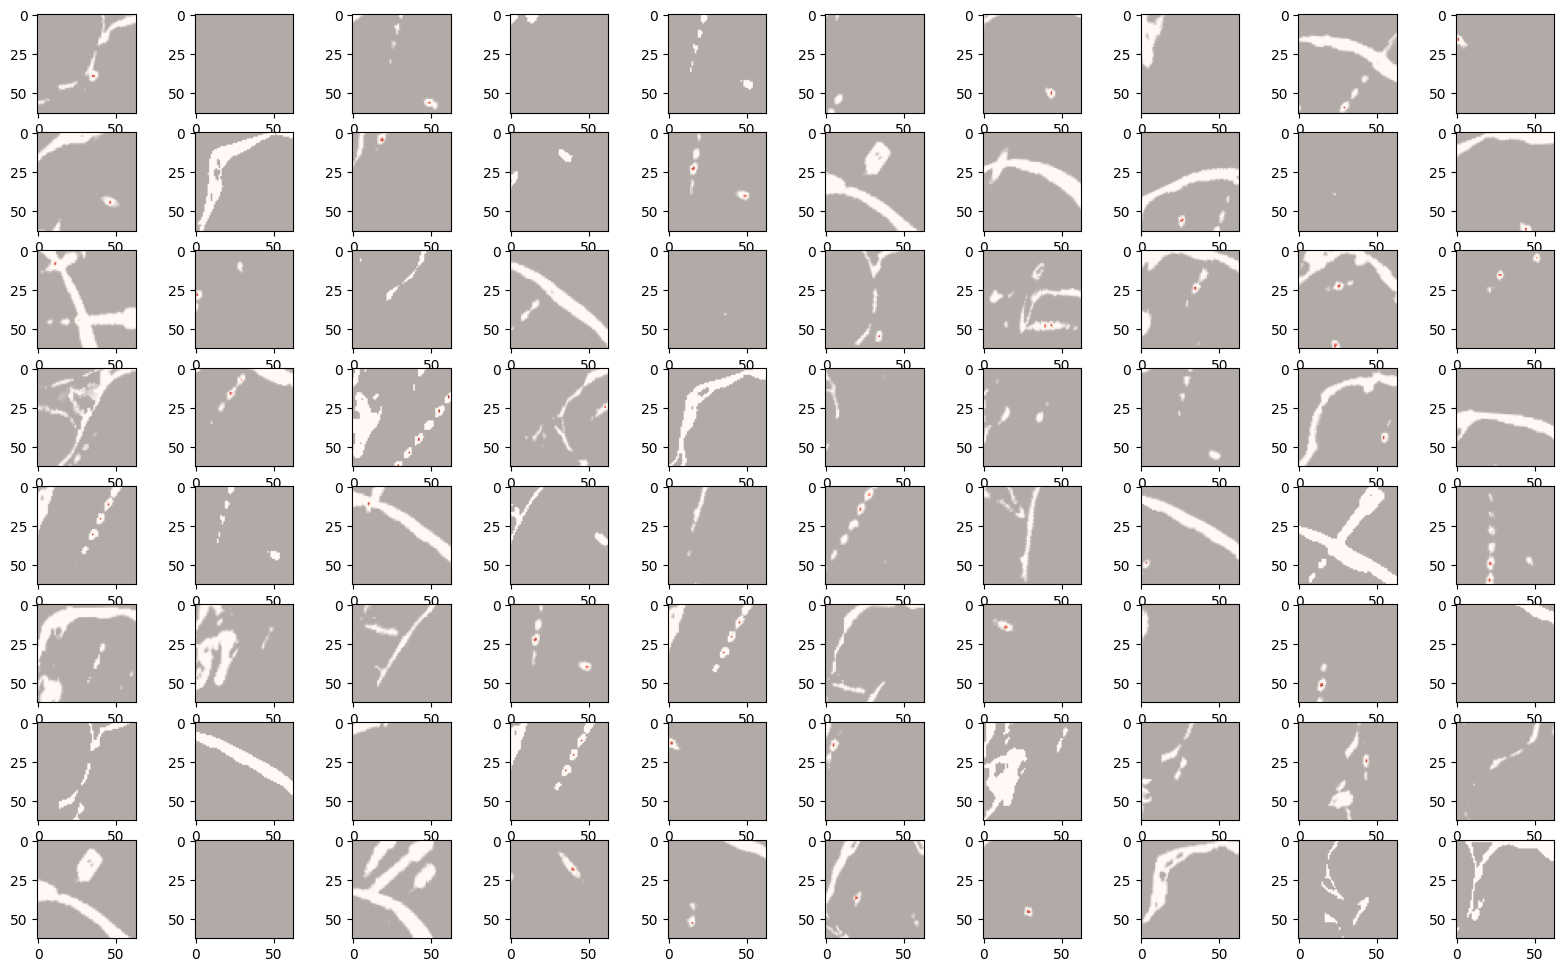

In [35]:
import matplotlib.pyplot as plt
from numpy.random import randint

plt.figure(figsize=(20,12))
nrows=8
ncols=10
for i,randi in enumerate(randint(low=0,high=arr_train.shape[0],size=(nrows*ncols,))):
  plt.subplot(nrows,ncols,i+1)
  plt.imshow(np.squeeze(arr_train[randi,:,30,:,0]),cmap='gray')
  plt.imshow(np.squeeze(arr_train[randi,:,30,:,1]),alpha=0.7,cmap="Reds")

In [36]:
np.unique(arr_train[:,:,:,:,1].flatten())
#values in range of float between 0 and 1

array([0.000000e+00, 9.433279e-09, 1.017554e-08, ..., 9.996398e-01,
       9.997635e-01, 1.000000e+00], dtype=float32)

In [37]:
#threshold = 0.5
#new_patch = arr_train[10,:,:,:,1].astype(np.int32)
#print(np.unique(new_patch[:,:,:].flatten()))

In [38]:
#arr_train_image = arr_train[:,0,:,:,:].reshape(arr_train.shape[0],1,arr_train.shape[2],arr_train.shape[3],arr_train.shape[4])
#arr_train_label = arr_train[:,1,:,:,:].reshape(arr_train.shape[0],1,arr_train.shape[2],arr_train.shape[3],arr_train.shape[4])

#arr_val_image = arr_val[:,0,:,:,:].reshape(arr_val.shape[0],1, arr_val.shape[2],arr_val.shape[3],arr_val.shape[4])
#arr_val_label = arr_val[:,1,:,:,:].reshape(arr_val.shape[0],1, arr_val.shape[2],arr_val.shape[3],arr_val.shape[4])

In [39]:
cd projects/ctb-akhanf/athurai3/contact_localization/

/project/6050199/athurai3/contact_localization


In [40]:
import generator
#arr_train = np.swapaxes(arr_train,1,4)
x_train_1 = arr_train[:,:,:,:,0]
x_train_f = x_train_1.reshape(x_train_1.shape[0], x_train_1.shape[1], x_train_1.shape[2], x_train_1.shape[3], 1)
y_train_1 = arr_train[:,:,:,:,1]
y_train_f = y_train_1.reshape(y_train_1.shape[0], y_train_1.shape[1], y_train_1.shape[2], y_train_1.shape[3], 1)

#threshold at 0.5
thresh = np.where(y_train_f>0.5,1, y_train_f)
thresh = np.where(thresh<0.5, 0, thresh)

datagen_train = generator.customImageDataGenerator()
new_train = datagen_train.flow(x_train_f, thresh, batch_size = 2)

In [41]:
x_train_f.shape

(540, 63, 63, 63, 1)

In [42]:
y_train_f.shape

(540, 63, 63, 63, 1)

In [43]:
len(y_train_f[1,:,:,:,0].flatten())

250047

In [44]:
thresh.shape

(540, 63, 63, 63, 1)

In [45]:
np.unique(thresh[:,:,:,:,:].flatten())

array([0., 1.], dtype=float32)

In [46]:
#input 
img_shape = (None,None,None,1)
input_layer = keras.layers.Input(img_shape)
x = keras.layers.ZeroPadding3D(padding= ((1,0),(1,0),(1,0)))(input_layer)


#block 1:
x = keras.layers.Conv3D(32,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Conv3D(32,(3,3,3),padding='same',activation='relu')(x)
#x = keras.layers.Conv3D(16,(3,3,3),padding='same',activation='relu')(x)

out_layer1 = x
x = keras.layers.MaxPooling3D((2,2,2))(x)
x = tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None)(x)


#block 2:
x = keras.layers.Conv3D(64,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Conv3D(64,(3,3,3),padding='same',activation='relu')(x)
#x = keras.layers.Conv3D(32,(3,3,3),padding='same',activation='relu')(x)

out_layer2 = x
x = keras.layers.MaxPooling3D((2,2,2))(x)
#x = tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None)(x)


#block 3:
x = keras.layers.Conv3D(128,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Conv3D(128,(3,3,3),padding='same',activation='relu')(x)
#x = keras.layers.Conv3D(64,(3,3,3),padding='same',activation='relu')(x)

out_layer3 = x
x = keras.layers.MaxPooling3D((2,2,2))(x)
#x = tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None)(x)


#block 4:
x = keras.layers.Conv3D(256,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Conv3D(256,(3,3,3),padding='same',activation='relu')(x)
#x = keras.layers.Conv3D(128,(3,3,3),padding='same',activation='relu')(x)

out_layer4 = x
x = keras.layers.MaxPooling3D((2,2,2))(x)

#bottleneck
x = keras.layers.Conv3D(512,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Conv3D(512,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Conv3DTranspose(filters= 128,kernel_size= 2, strides =(2,2,2))(x)
x = keras.layers.Conv3D(256,(2,2,2),padding='same',activation='relu')(x)
x = keras.layers.Concatenate(axis=4)([out_layer4,x])


#expanding path 

#block 5 (opposite 4)
x = keras.layers.Conv3D(256,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Conv3D(256,(3,3,3),padding='same',activation='relu')(x)
#x = keras.layers.Conv3D(128,(3,3,3),padding='same',activation='relu')(x)

x = keras.layers.Conv3DTranspose(64,kernel_size= 2,strides=2,padding='same')(x)
x = keras.layers.Conv3D(128,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Concatenate(axis=4)([out_layer3,x])
x = tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None)(x)


#block 6 (opposite 3)
x = keras.layers.Conv3D(128,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Conv3D(128,(3,3,3),padding='same',activation='relu')(x)
#x = keras.layers.Conv3D(64,(3,3,3),padding='same',activation='relu')(x)

x = keras.layers.Conv3DTranspose(32,kernel_size= 2,strides =2,padding='same')(x)
x = keras.layers.Conv3D(64,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Concatenate(axis=4)([out_layer2,x])
#x = tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None)(x)

#block 7 (opposite 2)
x = keras.layers.Conv3D(64,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Conv3D(64,(3,3,3),padding='same',activation='relu')(x)
#x = keras.layers.Conv3D(32,(3,3,3),padding='same',activation='relu')(x)

x = keras.layers.Conv3DTranspose(16,kernel_size= 2,strides = 2,padding='same')(x)
x = keras.layers.Conv3D(32,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Concatenate(axis=4)([out_layer1,x])
#x = tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None)(x)


# bloack 8 (opposite 1)
x = keras.layers.Conv3D(32,(3,3,3),padding='same',activation='relu')(x)
x = keras.layers.Conv3D(32,(3,3,3),padding='same',activation='relu')(x)
#x = keras.layers.Conv3D(16,(3,3,3),padding='same',activation='relu')(x)


#output layer
x = keras.layers.Cropping3D(cropping=((1, 0), (1, 0), (1, 0)), data_format=None)(x)
x = keras.layers.Conv3D(1,(1,1,1),padding='same',activation='sigmoid')(x)
model = keras.Model(input_layer,x)

In [47]:
# Compile the model
import math
optimizer = keras.optimizers.Adam()

from keras import backend as K


def dice_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)
    return score
    
def dice_loss_3D(y_true, y_pred):
    return (1 - dice_metric(y_true, y_pred))
    

loss = ['binary_crossentropy', dice_loss_3D]
metrics = ['binary_accuracy', dice_metric]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

history = model.fit(new_train, epochs=20, steps_per_epoch = 5)

Epoch 1/20
5/5 [==============================] - 125s 24s/step - loss: 0.4723 - binary_accuracy: 0.9891 - dice_metric: 0.0026
Epoch 2/20
5/5 [==============================] - 117s 23s/step - loss: 0.0659 - binary_accuracy: 0.9999 - dice_metric: 5.0430e-04
Epoch 3/20
5/5 [==============================] - 117s 23s/step - loss: 0.0139 - binary_accuracy: 0.9998 - dice_metric: 0.0043
Epoch 4/20
5/5 [==============================] - 118s 24s/step - loss: 0.0244 - binary_accuracy: 0.9998 - dice_metric: 0.0154
Epoch 5/20
5/5 [==============================] - 117s 23s/step - loss: 0.0070 - binary_accuracy: 0.9999 - dice_metric: 0.0258
Epoch 6/20
5/5 [==============================] - 116s 23s/step - loss: 0.0047 - binary_accuracy: 0.9999 - dice_metric: 0.0042
Epoch 7/20
5/5 [==============================] - 118s 23s/step - loss: 0.0034 - binary_accuracy: 0.9999 - dice_metric: 0.0052
Epoch 8/20
5/5 [==============================] - 116s 23s/step - loss: 0.0025 - binary_accuracy: 0.9999 - 

In [48]:
model.save(f'/home/athurai3/scratch/seeg_contacts_loc/derivatives/UNet-keras')

INFO:tensorflow:Assets written to: /home/athurai3/scratch/seeg_contacts_loc/derivatives/UNet-keras/assets


INFO:tensorflow:Assets written to: /home/athurai3/scratch/seeg_contacts_loc/derivatives/UNet-keras/assets


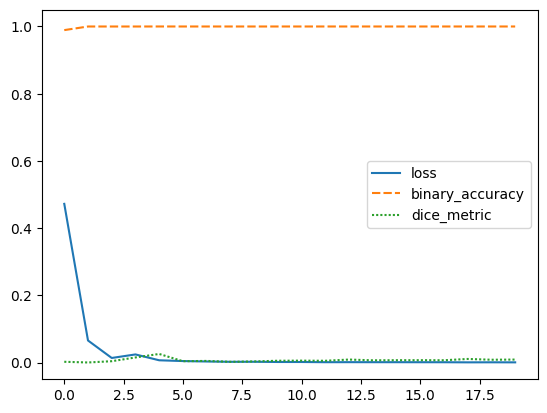

In [49]:
import seaborn as sns
#plot loss and metrics
loss_out_path = f'/home/athurai3/scratch/seeg_contacts_loc/derivatives/loss_metrics'
df = pd.DataFrame(history.history)
sns.lineplot(data=df)
pd.DataFrame(history.history).to_csv(loss_out_path)
plt.savefig(f'/home/athurai3/scratch/seeg_contacts_loc/derivatives/lossfunction_biophys.png')